In [84]:
import os
import pandas as pd
import numpy as np
from src.my_settings import settings

sett = settings()

In [85]:
pmc_coords = [(-30, -5, 64), (18, -2, 72)]
labels = ["leftPMC", "rightPMC"]

In [86]:
sub_label = '18'
task_label = 'loc'
run_label = '1'

In [87]:
from nilearn.maskers import NiftiSpheresMasker

masker = NiftiSpheresMasker(
    pmc_coords,
    radius=4,
    detrend=False,
    standardize=False,
    standardize_confounds=True,
    smoothing_fwhm=4,
    high_pass=0.008,
    t_r=sett["tr"],
    memory=os.path.join(sett["git_path"], "data", "nilearn_mem"),
    memory_level=1,
    verbose=2,
)

In [88]:
func_img = os.path.join(
            sett["derivatives_path"],
            f"sub-{sub_label}",
            "func",
            f"sub-{sub_label}_task-{task_label}_run-{run_label}{sett["space_label"]}_desc-preproc_bold.nii.gz",
            )


confounds_tsv = os.path.join(
                sett["derivatives_path"],
                f"sub-{sub_label}",
                "func",
                f"sub-{sub_label}_task-{task_label}_run-{run_label}_desc-confounds_timeseries.tsv",
            )

# load as pandas dataframe
confounds = pd.read_csv(confounds_tsv, sep="\t")

# filter
confounds = confounds[sett["confounds_of_interest"]]

# fill NaNs with 0
confounds = confounds.fillna(0)

# PHYSIO DATA REGRESSORS
physio_file = os.path.join(
    sett["bids_path"],
    "derivatives",
    "physio-out",
    f"sub-{sub_label}",
    f"sub-{sub_label}_task-{task_label}_run-{run_label}_desc-physioregressors.txt",
)

# if physio file exists, get the regressors
if os.path.exists(physio_file):
    print(
        f"Found physio file for sub-{sub_label} task-{task_label} run-{run_label}"
    )

    # read physio_file
    physio = pd.read_csv(physio_file, sep="\t", header=None)

    # rename columns to physio01, physio02, etc.
    physio.columns = [
        f"physio{i:02}" for i in range(1, physio.shape[1] + 1)
    ]

    # remove columns with only nans
    physio = physio.dropna(axis=1, how="all")

    # join confounds and physio
    confounds = pd.concat([confounds, physio], axis=1)

Found physio file for sub-18 task-loc run-1


In [89]:
time_series = masker.fit_transform(
    func_img, confounds=confounds
)

[Memory]0.0s, 0.0min    : Loading _filter_and_extract...


In [90]:
time_series.shape

(336, 2)

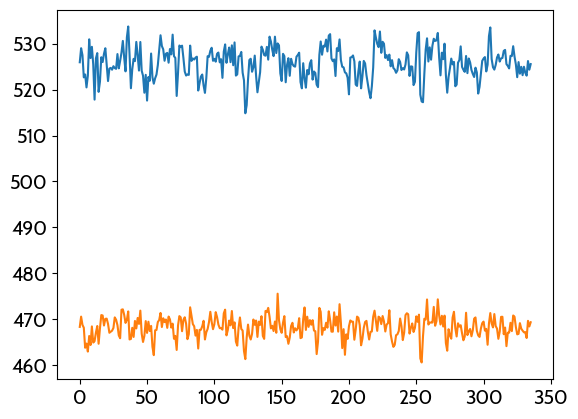

In [91]:
# plot the two time series
import matplotlib.pyplot as plt

plt.plot(time_series)

In [92]:
# get the events
events_file = os.path.join(
    sett["bids_path"],
    f"sub-{sub_label}",
    "func",
    f"sub-{sub_label}_task-{task_label}_run-{run_label}_events.tsv",
)

events = pd.read_csv(events_file, sep="\t")

# remove last 'Rest' event
events = events[:-1]

# compensate the onsets with a hemodynamic delay of 4 seconds
events["onset"] = events["onset"] + 3

# create onsets and durations in volumes, considering the TR, as integers
events["onset_volume"] = (events["onset"] / sett["tr"]).astype(int)
events["duration_volume"] = (events["duration"] / sett["tr"]).astype(int)

# get all the volume indexes for Rest
rest_volumes = []

# iterate on the events for which trial type is Rest
for idx, row in events[events["trial_type"] == "Rest"].iterrows():
    # set the start and end volume indexes for the rest period
    start = row["onset_volume"]
    end = start + row["duration_volume"]

    rest_volumes.append(np.arange(start, end))

# join all the rest periods
rest_volumes = np.concatenate(rest_volumes)
rest_volumes

array([ 10,  11,  12,  13,  14,  15,  16,  17,  50,  51,  52,  53,  54,
        55,  56,  57,  90,  91,  92,  93,  94,  95,  96,  97, 130, 131,
       132, 133, 134, 135, 136, 137, 170, 171, 172, 173, 174, 175, 176,
       177, 210, 211, 212, 213, 214, 215, 216, 217, 250, 251, 252, 253,
       254, 255, 256, 257, 290, 291, 292, 293, 294, 295, 296, 297])

In [93]:
# get the average of the rest period
rest_mean = time_series[rest_volumes,:].mean(axis=0)
rest_mean

array([523.62415, 467.65683], dtype=float32)

In [94]:
# get the signal change
signal_change = 100 * (time_series - rest_mean) / rest_mean
signal_change.shape

# get the bilateral signal change
signal_change_avg = signal_change.mean(axis=1)

Text(0, 0.5, 'BOLD signal change to Rest (%)')

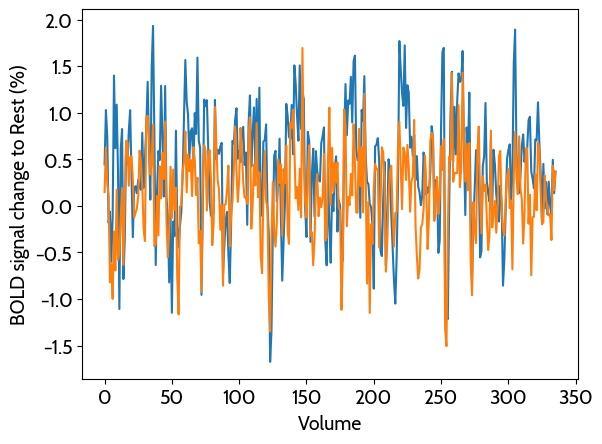

In [95]:
# plot the average of voxels_tcs
import matplotlib.pyplot as plt

plt.plot(signal_change)
plt.xlabel('Volume')
plt.ylabel('BOLD signal change to Rest (%)')

In [96]:
# now let's create the average timecourse of all the imagery periods
imagery_volumes = []

# iterate on the events for which trial type is Imagery
for idx, row in events[events["trial_type"] == "MotorImagery"].iterrows():
    # set the start and end volume indexes for the imagery period
    start = row["onset_volume"]
    end = start + row["duration_volume"]

    imagery_volumes.append(np.arange(start, end))

imagery_volumes

[array([18, 19, 20, 21, 22, 23, 24, 25]),
 array([58, 59, 60, 61, 62, 63, 64, 65]),
 array([ 98,  99, 100, 101, 102, 103, 104, 105]),
 array([138, 139, 140, 141, 142, 143, 144, 145]),
 array([178, 179, 180, 181, 182, 183, 184, 185]),
 array([218, 219, 220, 221, 222, 223, 224, 225]),
 array([258, 259, 260, 261, 262, 263, 264, 265]),
 array([298, 299, 300, 301, 302, 303, 304, 305])]

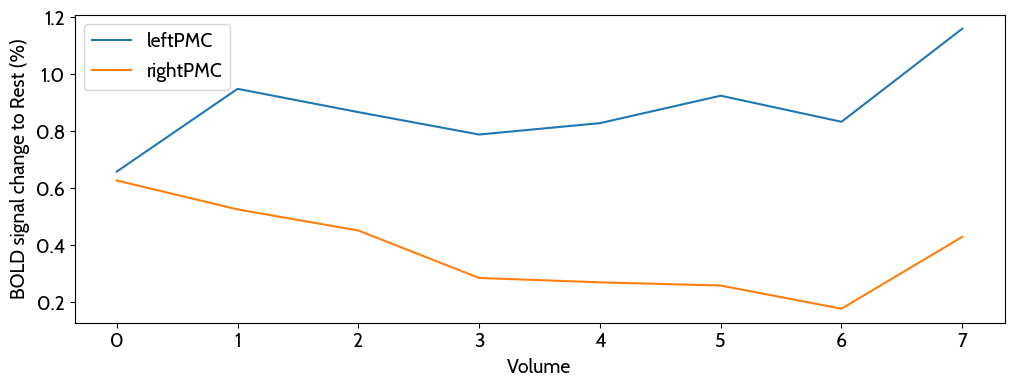

In [97]:
# Iterate on the length of imagery volumes
imagery_tcs = np.zeros((len(pmc_coords), len(imagery_volumes), 8))

for rr in range(len(pmc_coords)):
    for i, volumes in enumerate(imagery_volumes):
        imagery_tcs[rr, i, :] = signal_change[volumes, rr]

# plot both left and right PMC timecourses
plt.figure(figsize=(12, 4))

for rr in range(len(pmc_coords)):
    plt.plot(imagery_tcs[rr, :, :].mean(axis=0), label=labels[rr])

plt.xlabel('Volume')
plt.ylabel('BOLD signal change to Rest (%)')
plt.legend()